In [ ]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import * # for data cleaning

fastbook.setup_book()

<h1><b>First of all, let's get our dataset using the Azure Search API!</b></h1>

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '87b25fe04acf43b481263fb177f1a501')
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
classes = 'protective-face-mask','selfie'
path = Path('people')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in classes:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} person', max_images=250)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#291) [Path('people/selfie/00000069.jpg'),Path('people/selfie/00000129.jpg'),Path('people/selfie/00000004.jpg'),Path('people/selfie/00000045.jpg'),Path('people/selfie/00000023.jpg'),Path('people/selfie/00000081.jpg'),Path('people/selfie/00000082.jpg'),Path('people/selfie/00000088.jpg'),Path('people/selfie/00000019.jpg'),Path('people/selfie/00000036.jpg')...]

<h1><b>Now we can clear and structure our data to make it work properly.</b></h1>

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('people/selfie/00000082.jpg'),Path('people/selfie/00000037.jpg'),Path('people/protective-face-mask/00000070.jpg')]

In [ ]:
failed.map(Path.unlink);

In [ ]:
people = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = people.dataloaders(path)

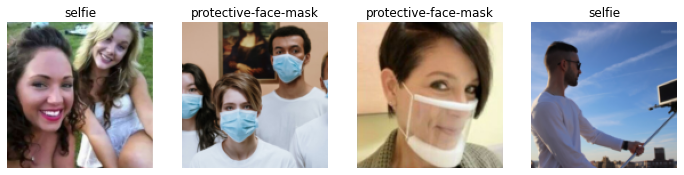

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
people = people.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = people.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [ ]:
people = people.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = people.dataloaders(path)

<h1>Let's train it now!</h1>

**In the training below, we use the default learning rate to fine tune it.**

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.193377,0.200780,0.105263,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.425786,0.074248,0.017544,00:13
1,0.336154,0.037656,0.017544,00:13


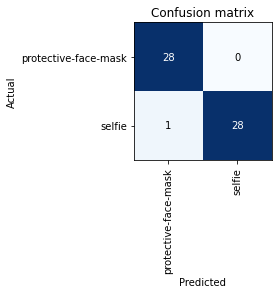

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

<h3><b>As we can see, the model runs properly (no significant outliers).</b></h3>

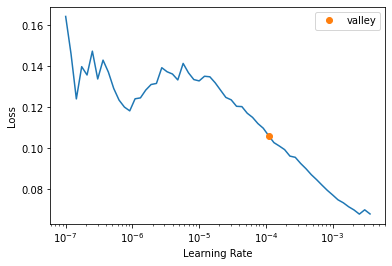

In [ ]:
lr = learn.lr_find()

<h2>We can look for an appropriate Learning Rate using the "learn.lr_find()" method.</h2><h3><b>The plot above shows us how the Loss progresses over the increasing value of the Learning Rate.</b></h3>

<h2>But I rememeber Jeremy told us we can choose the Learning Rate using the lowest Loss found in the training by dividing it by 10.</h2>

<h3><b>Therefore, our Learning Rate is gonna be: 0.037656/10 = 3.7e-3.</b></h3>

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3.7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.140141,0.449643,0.175439,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.252997,0.153584,0.052632,00:13
1,0.169322,0.022285,0.017544,00:13


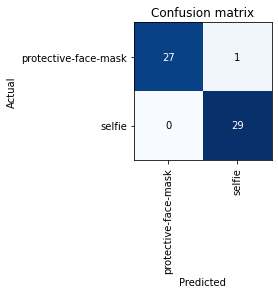

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

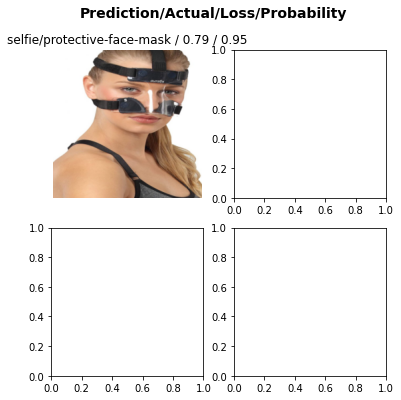

In [ ]:
interp.plot_top_losses(4, nrows=2)

<h2>We can see the model made a wrong prediction, but that is just a funny outlier from a noseless woman. <b>LMAO.</b></h2>

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<h1><b>Let's put our model to a real test.</b></h1>

<h1><b>The model's input is going to be a a picture taken from the user's webcam.</b></h1>

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<h2>The code below makes use of a JavaScrip library to get a picture out of user's webcam.</h2>

<IPython.core.display.Javascript object>

Saved to photo.jpg


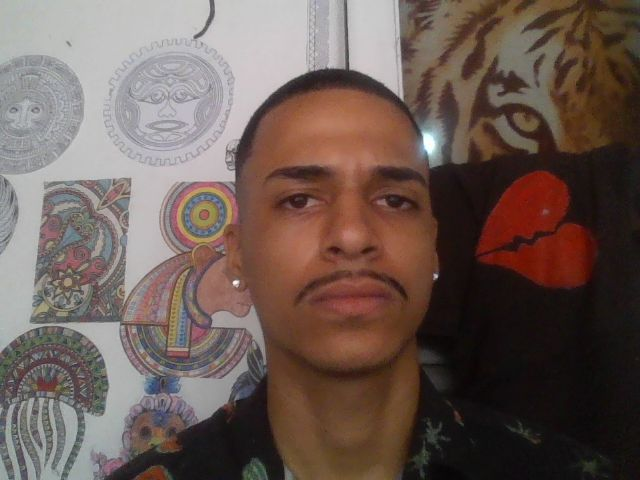

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<h1><b>I know I look good!</b></h1>

<h2><b>Let's turn our model into an application by using the method "export()"</b></h2>

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

<h2><b>And now it's time to predict if the user is wearing a mask... You better be using a mask, teacher!</b></h2>

In [ ]:
info = learn_inf.predict('photo.jpg')

In [ ]:
predicted_category = info[0]
predicted_category_IDX = info[1]
probability_of_masked, probability_of_unmasked = info[2]

In [ ]:
print("Your input category is predicted as: {}.\n\nThe model gives your input {:.0%} of being unmasked.\nThe model gives your input {:.0%} of being masked.".format(info[0].upper(), float(probability_of_unmasked), float(probability_of_masked)))

Your input category is predicted as: SELFIE.

The model gives your input 100% of being unmasked.
The model gives your input 0% of being masked.
